# TODO:

- ordenar no tempo
- verificar se dá pra inferir os nulls de acquisition baseado no padrão de consumo de spend

In [1]:
# spend['month'].value_counts()
#
# padrão de consumo dos que não tem default definido em acquisition
# executar depois de remover os null de acquisition
#
# spend_ids_set = set(spend['ids'])
# len(spend_ids_set)
# acquisition_ids_set = set(acquisition['ids'])
# len(acquisition_ids_set)
# diff_set = spend_ids_set - acquisition_ids_set
# len(diff_set)

# spend[spend['ids'].isin(diff_set)]

# Nubank Data Challenge - Exploratory Analysis

TODO: Intro

In [2]:
%%capture

""" Useful notebook definitions

Some usefull notebook definitions, like plots color scheme
and cell behavior were extracted to another notebook just
for a cleaner view
"""
%run ./notebook_utils.ipynb
default_color = 'purple'
default_light_color = 'white'
default_dark_color = 'rebeccapurple'
colormap = 'BuPu'

In [3]:
def plot_count(df, col, null_replace='NULL', x_adjust=0, y_adjust=0.45):
    plt.figure(figsize=(15,5))
    ax = sns.countplot(y=col, data=df.fillna(null_replace))
    print(ax)
    for p in ax.patches:
        count = p.get_width()
        percent = 100 * count / len(df[col])

        axis_init = 0 if p.get_width() < x_adjust + 500 else x_adjust
        color = default_dark_color if axis_init == 0 else default_light_color
        ax.annotate('{} - ({:.2f}%)'.format(count, percent),
                    (p.get_width() - axis_init, p.get_y() + y_adjust), 
                    color=color)

In [4]:
def normalize_months(df, id_col='ids', month_col='month', normalized_month_col='normalized_month'):
    """Set the max month of and ID in the dataset equals the max month of the dataset
    
    Find the max month of a datset and normalizes it backwards.
    Each ID of the dataset starts with month 0, but has a different number of months,
    but the last month of each ID represents the last month of the dataset,
    so we set this month as the max of the dataset, and recount other months backwards.
    
    We can find were is the very first month of each ID in the timeline.
    
    Example:
    a) The dataset has 36 months (0-35)
    b) the ID 1234 has 10 months in dataset (0-9)
    So the normalized months of ID 1234 will be 26-35. The ID 1234 become a client in month 26
    
    Parameters:
        - df: a pandas dataframe
        - id_col: the id column
        - month_col: the month column
        - normalized_month_col: the name of new column which will receive normalized months
        
    Retun:
        This function changes the dataset inplace and do not returns anything
    """
    # initiaizes new column with actual months
    df[normalized_month_col] = df[month_col]
    
    # max month in dataframe
    max_month = max(df[month_col])  
    
    # set of unique ids in dataset
    ids_set = set(df[id_col])  
    
    for current_id in ids_set:
        # subset of dataset with only the current id
        ids_subset = df[df[id_col] == current_id]
        
        # max month of current id
        max_current_id_month = max(ids_subset[month_col])
        
        # diff between max month of dataset and max month of current id
        diff_month = max_month - max_current_id_month
        
        # update months:
        for index, row in ids_subset.iterrows():
            df.set_value(index, normalized_month_col, row[month_col]+diff_month)

## Importing data and first look

In [5]:
base_path = '../data/raw/'
new_data_path = '../data/new/'

### Acquisition data

In [6]:
acquisition = pd.read_csv(base_path + 'acquisition_train.csv')
acquisition.shape
acquisition.info()
acquisition.describe()
acquisition.head()

(45000, 43)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
ids                                                 45000 non-null object
target_default                                      41741 non-null object
score_1                                             44438 non-null object
score_2                                             44438 non-null object
score_3                                             44438 non-null float64
score_4                                             45000 non-null float64
score_5                                             45000 non-null float64
score_6                                             45000 non-null float64
risk_rate                                           44438 non-null float64
last_amount_borrowed                                15044 non-null float64
last_borrowed_in_months                             15044 non-null float64
credit_limit                                        31200 non-null flo

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.00,45000.00,45000.00,45000.00,44438.00,15044.00,15044.00,31200.00,44438.00,18455.00,44303.00,44426.00,44438.00,33456.00,45000.00,22372.00,45000.00,29876.00,42767.00,45000.00,45000.00,45000.00
mean,347.98,100.01,0.50,99.93,0.30,13782.34,41.76,34381.95,71607.39,35.07,0.08,0.00,10.70,11.07,247.54,0.00,1.50,0.50,12.53,500.40,inf,33923.51
std,110.43,3.18,0.29,10.02,0.10,8077.57,10.25,36586.98,51858.97,21.66,0.27,0.08,4.59,4.60,146.12,0.00,1.11,0.50,126.53,287.97,nan,12692.41
min,0.00,86.19,0.00,60.66,0.00,1005.18,36.00,0.00,4821.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-999.00,0.00,403.00,12001.00
25%,270.00,97.87,0.25,93.20,0.22,7519.50,36.00,10000.00,45010.78,17.00,0.00,0.00,7.00,8.00,120.00,0.00,1.00,0.00,11.00,252.00,50948.25,22937.00
50%,340.00,100.02,0.50,99.97,0.29,12023.47,36.00,25647.00,61266.76,32.00,0.00,0.00,10.00,10.00,248.00,0.00,2.00,1.00,27.00,503.00,101779.00,33896.00
75%,420.00,102.14,0.75,106.64,0.36,19220.27,36.00,47086.75,86019.23,50.00,0.00,0.00,13.00,14.00,375.00,0.00,2.00,1.00,43.00,747.00,151337.25,44910.00
max,990.00,113.98,1.00,142.19,0.90,35059.60,60.00,448269.00,5000027.83,141.00,5.00,5.00,49.00,49.00,500.00,0.00,3.00,1.00,59.00,1000.00,inf,56000.00


,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.00,101.80,0.26,108.43,0.40,25033.92,36.00,0.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,nan,0.00,0.00,18.00,18.00,07:52:34,444,outlook.com,nan,2,0.00,51.00,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.00,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.00,97.06,0.94,92.00,0.24,nan,nan,39726.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.00,0.00,0.00,14.00,14.00,02:34:29,346,gmail.com,0.00,1,0.00,17.00,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.00,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.00,100.03,0.35,112.89,0.29,7207.92,36.00,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,nan,0.00,0.00,10.00,nan,00:60:02,6,gmail.com,nan,2,nan,9.00,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.00,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.00,101.60,0.99,94.90,0.32,nan,nan,54591.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,nan,1.00,0.00,19.00,19.00,11:20:49,406,spgov.com,nan,3,nan,38.00,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.00,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.00,98.47,0.53,118.13,0.18,nan,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,nan,0.00,0.00,11.00,nan,13:39:03,240,gmail.com,0.00,2,1.00,46.00,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.00,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


### Spent data

In [7]:
spend = pd.read_csv(base_path + 'spend_train.csv')
spend.shape
spend.info()
spend.describe()
spend.head()

(980818, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980818 entries, 0 to 980817
Data columns (total 7 columns):
ids                  980818 non-null object
credit_line          980818 non-null int64
month                980818 non-null int64
spends               980818 non-null float64
revolving_balance    980818 non-null float64
card_request         980818 non-null int64
minutes_cs           980818 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 52.4+ MB


,credit_line,month,spends,revolving_balance,card_request,minutes_cs
count,980818.00,980818.00,980818.00,980818.00,980818.00,980818.00
mean,6450.70,12.10,2878.07,481.07,0.09,2.79
std,4564.60,8.52,3529.03,1431.83,0.29,6.64
min,506.00,0.00,0.00,0.00,0.00,0.00
25%,2948.00,5.00,334.76,0.00,0.00,0.00
50%,5314.00,11.00,1568.16,1.53,0.00,0.00
75%,8763.00,18.00,4129.00,141.66,0.00,1.72
max,20484.00,35.00,20462.23,20369.44,1.00,75.58


,ids,credit_line,month,spends,revolving_balance,card_request,minutes_cs
0,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,0,6305.06,35.56,1,0.00
1,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,1,4199.99,3406.59,0,0.00
2,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,2,7167.94,0.00,0,0.00
3,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,3,16631.05,0.00,1,5.55
4,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,4,115.29,0.00,0,6.89


In [8]:
ids_default_null = list(acquisition[acquisition['target_default'].isnull()].head()['ids'])

In [9]:
spend_default_slice = spend[spend['ids'].isin(ids_default_null)].sort_values(by=['ids', 'month'])

In [10]:
%%capture
spend_default_slice['paid'] = spend_default_slice['spends'] - spend_default_slice['revolving_balance']
spend_default_slice['p_paid'] = spend_default_slice['paid'] / spend_default_slice['spends']
spend_default_slice['p_revolving'] = spend_default_slice['revolving_balance'] / spend_default_slice['spends']
spend_default_slice['acum'] = 0.0
previous = -1
for i,row in spend_default_slice.iterrows():
    if previous == -1:
        spend_default_slice.set_value(i, 'acum', spend_default_slice.get_value(i, 'revolving_balance'))
    else:
        spend_default_slice.set_value(i, 'acum', spend_default_slice.get_value(i, 'revolving_balance') + spend_default_slice.get_value(previous, 'acum'))
    previous = i

In [11]:
spend_default_slice

,ids,credit_line,month,spends,revolving_balance,card_request,minutes_cs,paid,p_paid,p_revolving,acum
829399,192f9f43-847d-a59c-5698-811393b23cbd,8720,0,6624.26,0.00,1,0.00,6624.26,1.00,0.00,0.00
829400,192f9f43-847d-a59c-5698-811393b23cbd,8720,1,513.31,0.00,0,0.00,513.31,1.00,0.00,0.00
829401,192f9f43-847d-a59c-5698-811393b23cbd,8720,2,116.55,0.05,0,8.65,116.50,1.00,0.00,0.05
829402,192f9f43-847d-a59c-5698-811393b23cbd,8720,3,158.64,0.00,0,4.33,158.64,1.00,0.00,0.05
829403,192f9f43-847d-a59c-5698-811393b23cbd,8720,4,2767.02,372.38,0,0.00,2394.64,0.87,0.13,372.43
829404,192f9f43-847d-a59c-5698-811393b23cbd,8720,5,8695.41,0.00,0,0.00,8695.41,1.00,0.00,372.43
829405,192f9f43-847d-a59c-5698-811393b23cbd,8720,6,7437.85,0.03,0,10.89,7437.82,1.00,0.00,372.46
829406,192f9f43-847d-a59c-5698-811393b23cbd,8720,7,8629.86,0.03,0,0.00,8629.83,1.00,0.00,372.49
829407,192f9f43-847d-a59c-5698-811393b23cbd,8720,8,5160.21,0.03,0,0.00,5160.18,1.00,0.00,372.52
829408,192f9f43-847d-a59c-5698-811393b23cbd,8720,9,245.89,237.88,0,0.00,8.01,0.03,0.97,610.40


In [16]:
%%capture
spend['paid'] = spend['spends'] - spend['revolving_balance']
spend['p_paid'] = spend['paid'] / spend['spends']
spend['p_revolving'] = spend['revolving_balance'] / spend['spends']

In [23]:
rev_df = spend[spend['p_revolving'] > 0.9]
rev_ids = rev_df['ids']
rev_set = set(rev_ids)
len(rev_ids)
len(rev_set)

55403

30596

In [25]:
rev_df2 = rev_df[rev_df.groupby('ids')['ids'].transform('size') > 1]
len(rev_df2)

40280

In [26]:
vc = rev_ids.value_counts()

In [28]:
vc.nlargest(6662)

03447590-f444-bfb0-5be8-656a30ed7862    9
19c70aed-f4d3-e3e2-d55d-5479a2c67849    9
f2b9e55c-b311-6481-557e-70c9949010f0    9
684ff6d8-34a5-99e8-3297-dc16cd499fc2    9
d98373b8-bb6d-bb5d-a0a0-c312ba812bbe    8
85ac151a-ffbf-123e-6bdd-9cad9fd425b0    8
f79341e3-e91b-aee3-d756-91977a4c5acd    8
6038c593-b2e8-39d3-2e1e-cf17c8979ff9    8
a481c47b-ac96-a3c5-a12f-4ea7789931ff    8
8069ffe1-2732-0c24-0db9-d9c954222723    8
31623f61-31de-2489-dc8f-f5ea229c5143    8
730be30a-4027-12d5-1014-a95663c87f14    7
a21648de-041a-63a5-33ae-06f9d8c4b473    7
3e736a23-63a8-0172-5f62-2110d30af72d    7
ea45fe67-dd40-89e4-d663-fe6f18fdba51    7
ed67e8d8-3947-5f22-135e-fd5d56872988    7
5595ce87-cc6f-22d4-83a5-bbe497b6390f    7
04800b3c-be2f-d818-2e98-8d3e0c92e9a0    7
29e6eab7-fcff-00d0-d055-74205854365a    7
5589a888-c018-0172-ea64-eb0b53eb4eec    7
750382a4-1217-d01f-5b45-0495dd714a9b    7
7cbd5306-b3e6-69c7-8d15-7984bc42bcb0    7
2988044a-6188-f3a9-4a60-4ac86b1ade90    7
ba814d53-a65d-3e2e-c1b9-0837615eda

## Acquisition data - Fraud Analysis

AxesSubplot(0.125,0.125;0.775x0.755)


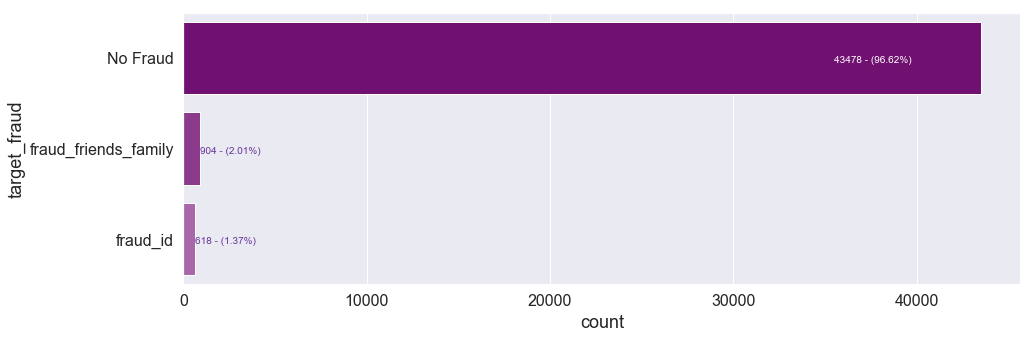

In [8]:
plot_count(acquisition, 'target_fraud', null_replace='No Fraud', x_adjust=8000)

## Acquisition data - Default Analysis

AxesSubplot(0.125,0.125;0.775x0.755)


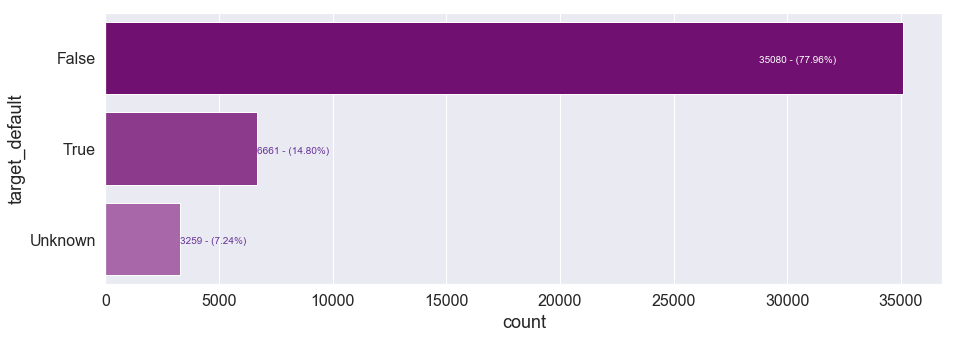

In [9]:
plot_count(acquisition, 'target_default', null_replace='Unknown', x_adjust=6300)

### Unkown data
There is a small number of observations on our dataset wich we don't know if was defaulted or not, let's exclude them

AxesSubplot(0.125,0.125;0.775x0.755)


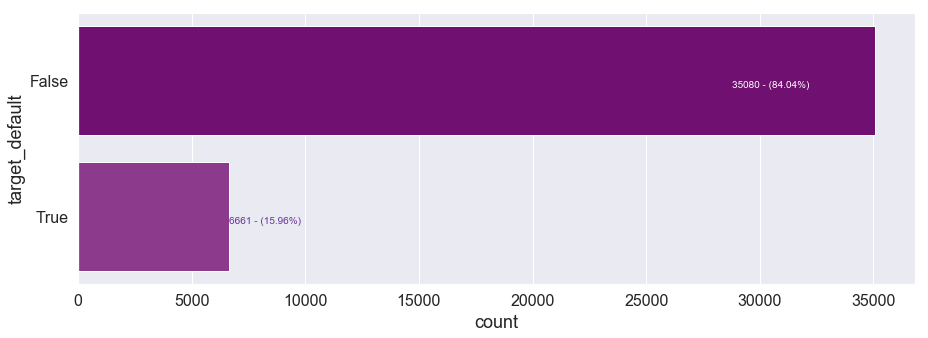

In [10]:
acquisition.dropna(subset=['target_default'], inplace=True)
plot_count(acquisition, 'target_default', null_replace='Unknown', x_adjust=6300)

## Fraud vs Default

Let's take a look into only the subset of our data that refers to fraud. How the default is present in this piece of data?

AxesSubplot(0.125,0.125;0.775x0.755)


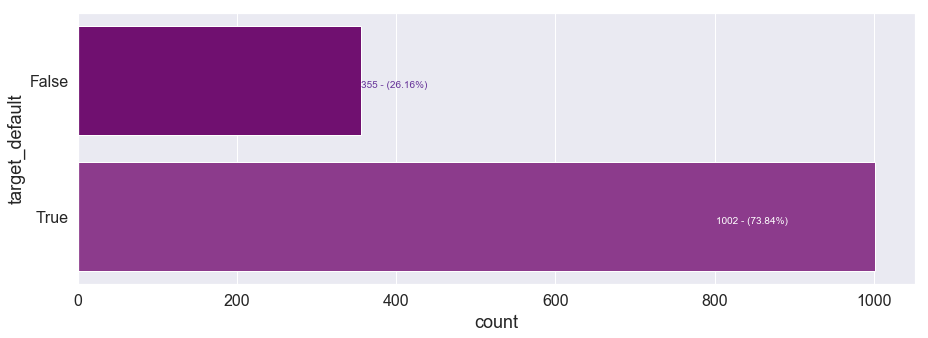

In [11]:
acquisition_fraud = acquisition.dropna(subset=['target_fraud'], inplace=False)
plot_count(acquisition_fraud, 'target_default', null_replace='Unknown', x_adjust=200)

### Default without fraud

As we can see, almost 74% of our frauds end in default. What is an expected behavior.

We need to take care of removing fraud cases from our analysis when talking about default. Makes no sense trying to predict the probability of default (PD) when dealing with a fraud case, once we already know most of the frauds are made with intention of default. 

Ideally, the fraud analysis will run before the PD analysis, so a default caused by a fraud is, first of all, a mistake in fraud analysis.

From this point on, when analyzing PD, we will always look for a view of the dataset without fraud.

AxesSubplot(0.125,0.125;0.775x0.755)


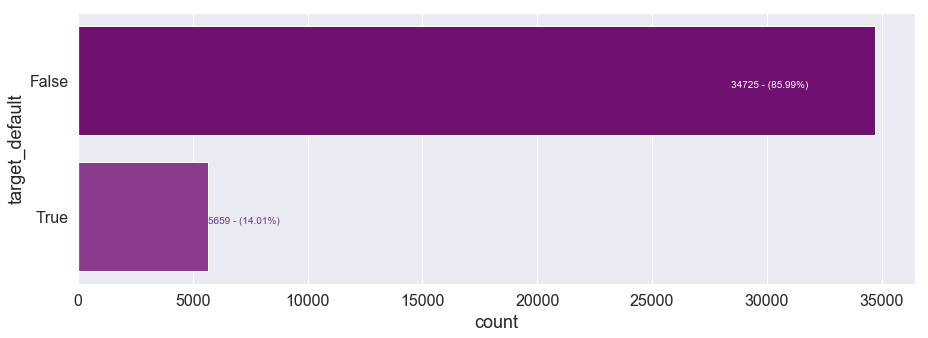

In [12]:
acquisition_without_fraud = acquisition[acquisition['target_fraud'].isnull()]
plot_count(acquisition_without_fraud, 'target_default', null_replace='Unknown', x_adjust=6300)

## Probability of Default (PD) - Naive Approach

As a naive approach, we can consider as PD the current percent of default (14.01%). Let's resume this point soon

In [13]:
acquisition_default = acquisition_without_fraud[acquisition_without_fraud['target_default'] == True]['ids'].count()
acquisition_ok = acquisition_without_fraud[acquisition_without_fraud['target_default'] == False]['ids'].count()
naive_pd = acquisition_default / (acquisition_default + acquisition_ok)

# TODO: SUBIR ISSO PARA ANTES DO PROCESSAMENTO DE ACQUISITION e renomear acquisition
## Spent Data - Normalize months

Let's take a break from the acquisition analysis and take a look into the spent data.

Each ID of the dataset starts with month 0, but has a different number of months, but the last month of each ID represents the last month of the dataset, so we set this month as the max of the dataset, and recount other months backwards.

## TODO: olhar um id que defaultou e verificar se é razoável assumir que o default aconteceu no último mês

In [14]:
if os.path.isfile(new_data_path + 'spend_normalized_month.csv'):
    spend = pd.read_csv(new_data_path + 'spend_normalized_month.csv')
else:
    normalize_months(spend)
    spend.to_csv(new_data_path + 'spend_normalized_month.csv')
spend.head()

,Unnamed: 0,ids,credit_line,month,spends,revolving_balance,card_request,minutes_cs,normalized_month
0,0,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,0,6305.06,35.56,1,0.00,16
1,1,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,1,4199.99,3406.59,0,0.00,17
2,2,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,2,7167.94,0.00,0,0.00,18
3,3,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,3,16631.05,0.00,1,5.55,19
4,4,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,17941,4,115.29,0.00,0,6.89,20


### Evolution of customers in time

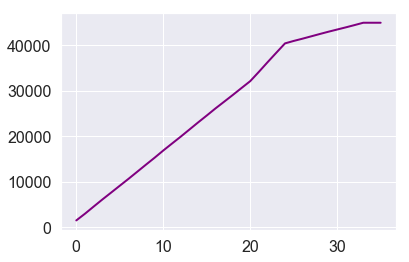

In [15]:
# TODO: colocar meses no eixo x
sns.lineplot(data=spend['normalized_month'].value_counts())

In [ ]:
%%capture
# TODO: aqui tem o problema dos apagados, mas subindo esse problema não vai acontecer
# e dá pra fazer uma análise dos default unknown com member since
acquisition['member_since'] = 0
ids_set = set(spend['ids'])
print('start')
count = 0
for current_id in ids_set:
    count += 1
    ids_subset = spend[spend['ids'] == current_id]
    min_current_id_month = min(ids_subset['normalized_month'])
    idx = acquisition[acquisition['ids'] == current_id].index
    acquisition.set_value(idx, 
                          'member_since', 
                          min_current_id_month)

In [ ]:
acquisition.head()

## Merging datasets

Let's create a new merged dataset with some calculated columns as well

## Separate a dataset with only default

We need to understand better the default cases, so, we need to separate this cases and take a closer look into this

In [ ]:
# We need to force comparing == True because of the null values in column
default_df = train_df[train_df['target_default'] == True]
default_df.shape

### Basic inspecting into default dataset

In [ ]:
default_df.info()
default_df.describe()

default_df.head()
default_df.tail()

### Closer look into some columns

#### Single value columns

The columns `channel` and `external_data_provider_credit_checks_last_2_year` have only unique values in each of them.

They should be removed.

In [ ]:
default_df['channel'].value_counts()
default_df['external_data_provider_credit_checks_last_2_year'].value_counts()

default_df.drop(['channel','external_data_provider_credit_checks_last_2_year'], axis=1, inplace=True)

#### Sparse columns (less than 10%)
- job_name
- reason
- zip - com muitos valores podem ser códigos de regiões grandes, pode ser substituído pelo estado?
- job_name
- shipping_zip_code

#### Colunas que não batem
- state

#### Comparar com não default
- real_state
- n_bankruptcies
- n_defaulted_loans

#### Abrir o dicionário
- profile_tags

#### Agrupar por sistema
- user_agent

In [ ]:
default_df['score_1'].value_counts()
default_df['score_2'].value_counts()
default_df['reason'].value_counts()
default_df['state'].value_counts()
default_df['zip'].value_counts()
default_df['job_name'].value_counts()
default_df['real_state'].value_counts()
default_df['marketing_channel'].value_counts()
default_df['shipping_state'].value_counts()
default_df['shipping_zip_code'].value_counts()
default_df['profile_tags'].value_counts()
default_df['user_agent'].value_counts()
default_df['last_borrowed_in_months'].value_counts()
default_df['ok_since'].value_counts()
default_df['n_bankruptcies'].value_counts()
default_df['n_defaulted_loans'].value_counts()

In [ ]:
# verificando se prefixos correlacionam com estados
phone_prefix = test_df['profile_phone_number'].map(lambda x: x[:2])
phone_prefix.name = 'prefix_phone_number'
test_df = pd.concat([test_df, phone_prefix], axis=1)
test_df.head()

### Removing unvaluable columns

The columns listed below do not aggregate information for our analysis:
- channel - there is only one value, namely NCqL3QBx0pscDnx3ixKwXg==
- external_data_provider_first_name
- profile_phone_number
- profile_tags
- user_agent

#### Drop missing in target

Missing values in our target variable represents 7,24%. Let's drop.

In [ ]:
train_df.dropna(subset=['target'], inplace=True)
train_df.shape
train_df.info()

### Remove unknown columns

We need to remove all unknown columns at acquisition time

TODO: Verificar as colunas:
- risk_rate

In [ ]:
unknown = ['credit_limit']
for col in unknown:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

### Check consistency values

Valores negativos por exemplo

### Remove ids

TODO: verificar essa parte de separar a variável

Now we have to separate the column `ids` to create submission file at end and drop this column

In [ ]:
train_df.drop('ids', axis=1, inplace=True)
test_df.drop('ids', axis=1, inplace=True)

### Other Missing values

As we can see, there is missing values in our target column

In [ ]:
missing_value_columns = train_df.columns[train_df.isnull().any()].tolist()
train_df_missing = train_df[missing_value_columns]

msno.bar(train_df_missing,figsize=(20,8),color=default_color,fontsize=18,labels=True)
msno.matrix(train_df_missing,figsize=(20,8),fontsize=14)
msno.heatmap(train_df_missing,figsize=(20,8),cmap=colormap)

## Fraud analysis

Faça uma análise dos casos de fraude. Qual a relação deles com os casos de inadimplência?

## Behavior analysis

Analisando a distribuição do volume de compras em 3 meses dos clientes (variável pv_3m), você diria que ela segue uma distribuição normal? Há algo de estranho nela? Se sim, qual seria a justificativa ou hipótese para tal?